### Hate Speech Detection

In today’s online environment, hate speech remains a significant issue, especially on social media platforms. Identifying and addressing hateful content, such as tweets that promote racism or sexism, is critical to fostering a safer and more inclusive digital space. This project aims to develop a machine learning model that can automatically detect hate speech in tweets. By analyzing the text of tweets and classifying whether a tweet contains racist or sexist sentiments (hate speech) or not. This can help moderators, researchers, and organizations combat toxic behavior online.



#### Project Objective

The objective of this project is to build a binary classification model that predicts whether a tweet contains hate speech based on its text content. Specifically:

    Label 1: The tweet contains hate speech (racist or sexist content).  
    Label 0: The tweet does not contain hate speech.  
    
The model will be trained on a dataset of 31,962 labeled tweets and then evaluated on its ability to generalize to unseen data.

#### Data Dictionary

The dataset is provided in CSV format and contains the following columns:  

1. tweet_id: A unique identifier for each tweet.  
2. label: Target label: 1 if the tweet contains hate speech (racist/sexist), 0 otherwise.  
3. tweet: The text content of the tweet.

### Model Development

In [104]:
# importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [105]:
# Loading Twitter Dataset
df = pd.read_csv('Twitter Sentiments.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [106]:
# Basic Inforamtion on Twitter Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


### Data Preprocessing

In [107]:
# Function to remove @user in tweet
def remove_pattern(input_txt, pattern):
    return re.sub(pattern, "", input_txt)


In [108]:
# Creating columns of cleaned tweets (@user removed)
df['cleaned_tweet'] = df["tweet"].apply(lambda x: remove_pattern(x, "@[A-Za-z0-9]+"))

In [109]:
# Check cleaned_tweet column
df.head()

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [110]:
# Custom tokenizer (maintain hashtags)
def custom_tokenizer(tweet):
    # Regex to match words, numbers, hashtags, and mentions as individual tokens
    tokens = re.findall(r'\#\w+|\w+', tweet)
    return tokens

In [111]:
# Function to clean tweets
def clean_tweet(tweet):
    # Remove special characters, numbers, and punctuation
    tweet = re.sub(r"[^a-zA-Z\s#]", "", tweet)
    # Convert text to lowercase
    tweet = tweet.lower()
    # Remove extra spaces
    tweet = re.sub(r"\s+", " ", tweet).strip()
    return tweet

In [112]:
# Function to remove stopwords
def remove_stopwords(tweet):
    # creating stopwords in english
    stop_words = set(stopwords.words("english"))
    # tokenise words
    words = custom_tokenizer(tweet)
    # remove stopwords
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [113]:
# Standardising tweets
df['cleaned_tweet'] = df['cleaned_tweet'].apply(clean_tweet)
df.head()

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i cant use cause they ...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now #motivation


In [114]:
# Remove special characters, numbers, and punctuations
df['cleaned_tweet'] = df['cleaned_tweet'].apply(remove_stopwords)
df.head()

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cant use cause dont offer ...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,#model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguide society #motivation


In [115]:
# Function to Tokenise and Stem
def token_stemmer(tweet):
    #Tokenise tweets
    tweet = custom_tokenizer(tweet)
    #stem Tweets
    stemmer = PorterStemmer()
    stemmed_tokens = []
    for token in tweet:
        if token.startswith('#'):
            # Keep hashtags intact
            stemmed_tokens.append(token)
        else:
            # Stem other words
            stemmed_tokens.append(stemmer.stem(token))
    
    return " ".join(stemmed_tokens)

In [116]:
# Tokenise and Stem tweets
df['cleaned_tweet'] = df['cleaned_tweet'].apply(token_stemmer)
df.head()

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct #run
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit cant use caus dont offer wh...
2,3,0,bihday your majesty,bihday majesti
3,4,0,#model i love u take with u all the time in ...,#model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguid societi #motivation


### Exploratory Data Analysis

##### Generating a WordCloud for All tweets

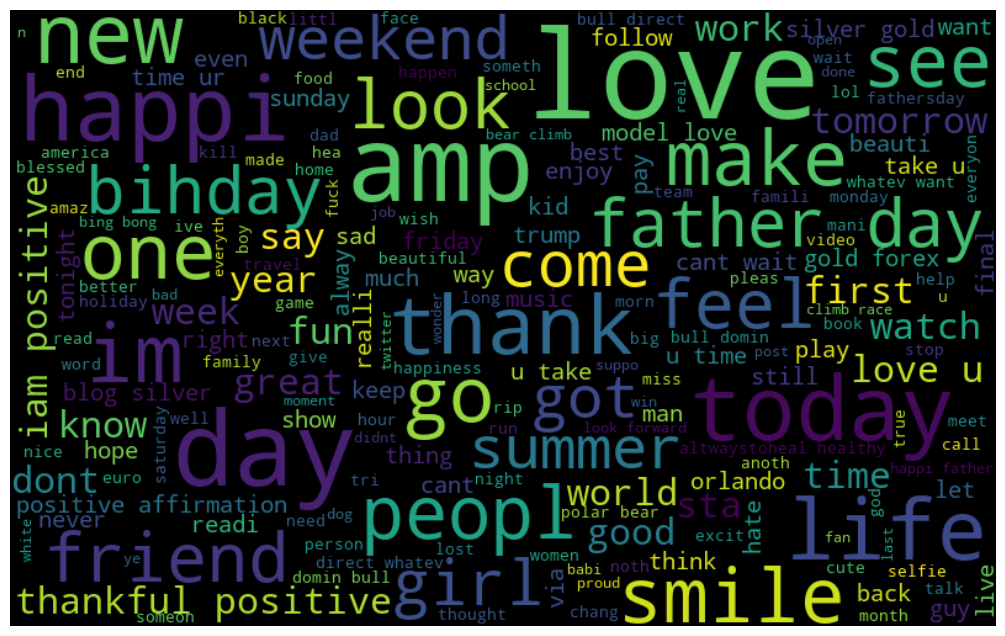

In [117]:
# list of All tweets
all_tweets = " ".join([tweet for tweet in df['cleaned_tweet']])

# Generating Wordcloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_tweets)

# Visualise WOrdCloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### Generating a WordCloud for Positive tweets

In [118]:
# Creating a DataFrame of Positive tweets
df_positive = df[df['label']==0]
df_positive.head()

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct #run
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit cant use caus dont offer wh...
2,3,0,bihday your majesty,bihday majesti
3,4,0,#model i love u take with u all the time in ...,#model love u take u time ur
4,5,0,factsguide: society now #motivation,factsguid societi #motivation


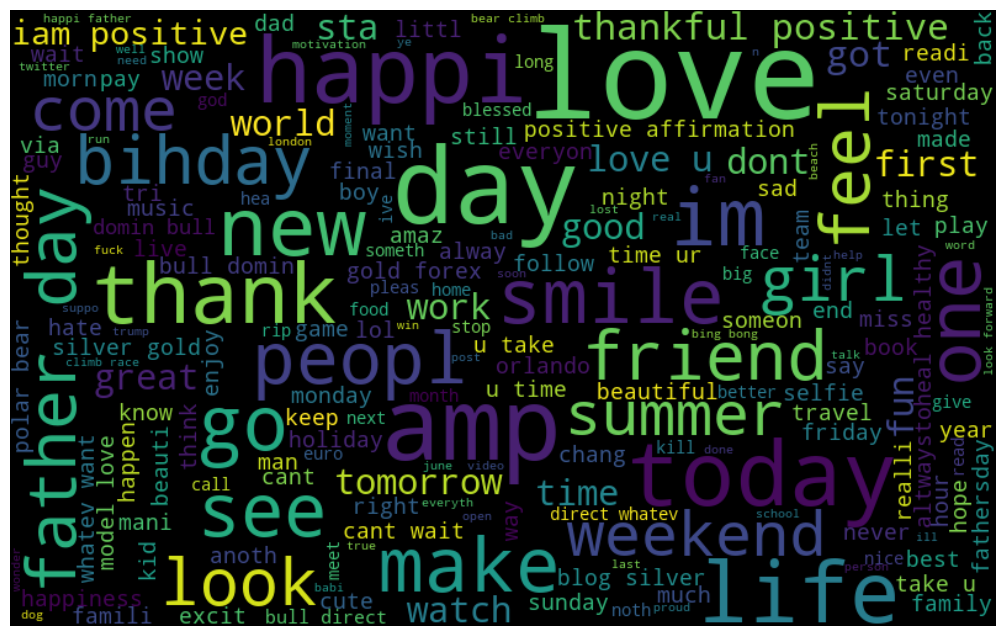

In [119]:
# list of All Positive tweets
all_pos_tweets = " ".join([tweet for tweet in df_positive['cleaned_tweet']])

# Generating Wordcloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_pos_tweets)

# Visualise WOrdCloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### Generating a Wordcloud for hateful tweets

In [120]:
# Creating a DataFrame of hateful tweets
df_hateful = df[df['label']== 1]
df_hateful.head()

,id,label,tweet,cleaned_tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...,#cnn call #michigan middl school build wall ch...
14,15,1,no comment! in #australia #opkillingbay #se...,comment #australia #opkillingbay #seashepherd ...
17,18,1,retweet if you agree!,retweet agre
23,24,1,@user @user lumpy says i am a . prove it lumpy.,lumpi say prove lumpi
34,35,1,it's unbelievable that in the 21st century we'...,unbeliev st centuri wed need someth like #neve...


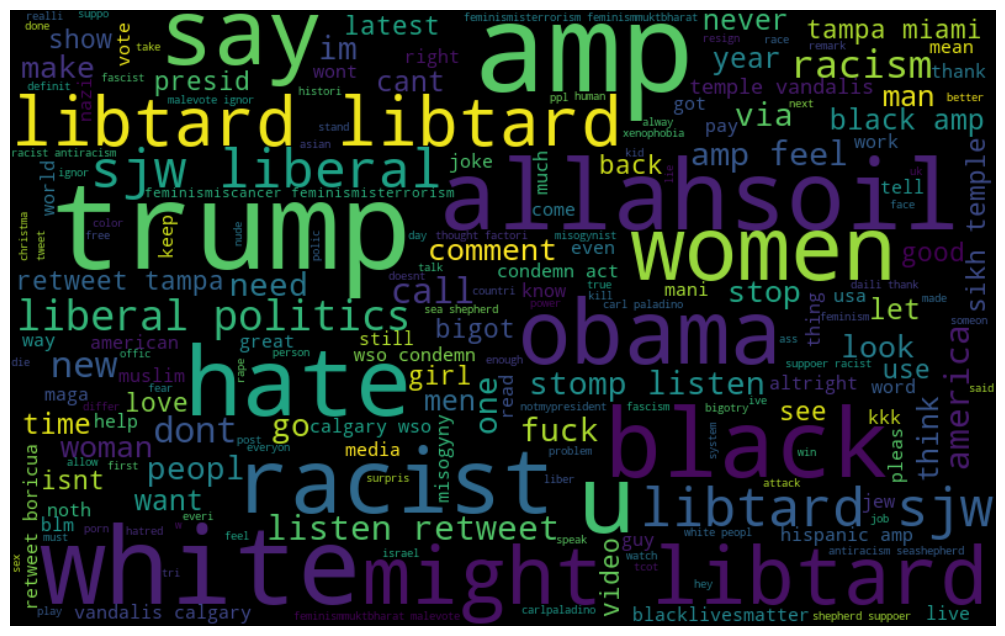

In [121]:
# list of All tweets
all_hate_tweets = " ".join([tweet for tweet in df_hateful['cleaned_tweet']])

# Generating Wordcloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_hate_tweets)

# Visualise WOrdCloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### Exploring Hashtags

In [122]:
# extract the hashtag
def hashtag_extract(tweets):
    hashtags = []
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags    

In [123]:
# extracting hashtags from Positive tweets
hash_positive = hashtag_extract(df_positive['cleaned_tweet'])

# extracting hashtags from Hateful tweets
hash_hateful = hashtag_extract(df_hateful['cleaned_tweet'])

In [124]:
# Flatten list of Hashtags
hash_positive = [item for sublist in hash_positive for item in sublist]

hash_hateful = [item for sublist in hash_hateful for item in sublist]

In [125]:
# count Occurrences of Positive and Hateful Hastags
counts_hash_positves = Counter(hash_positive)

counts_hash_hatefuls = Counter(hash_hateful)


In [126]:
#freq = nltk.FreqDist(hash_positive)
#freq

##### Visualising Top Hastags (Positive and Hateful)

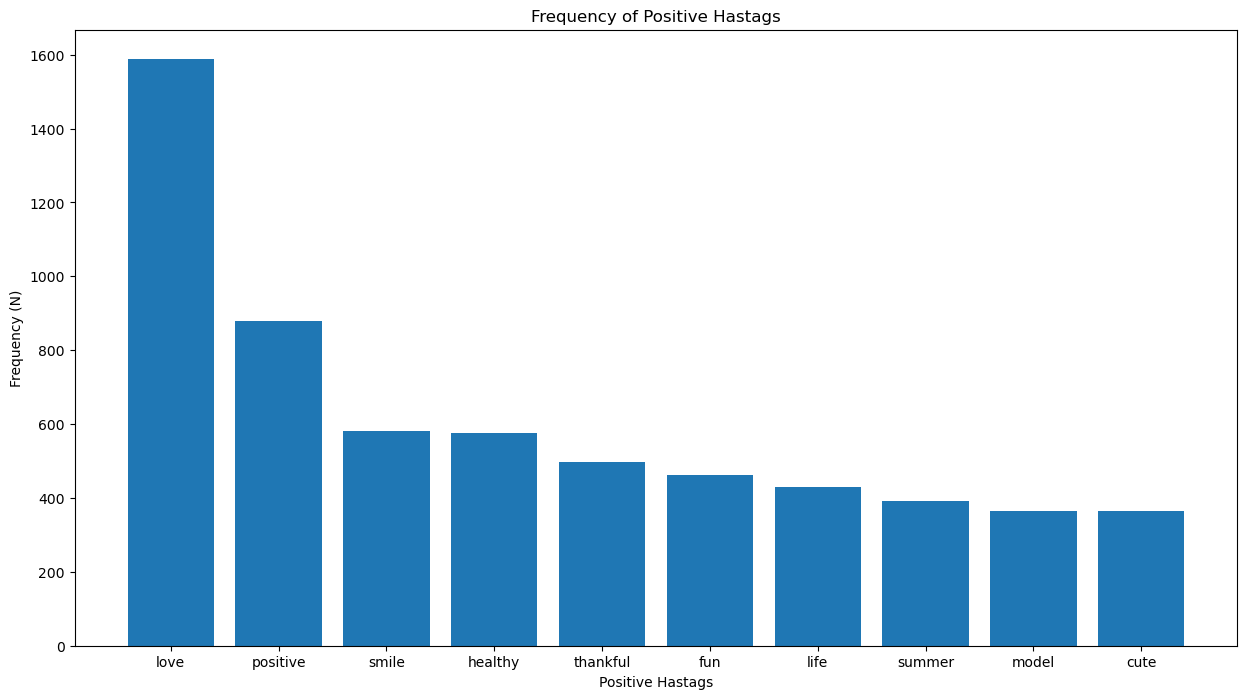

In [127]:
# Extract the Positive Hashtag items and their counts
positive_hastags = list(counts_hash_positves.keys())
counts_poshash = list(counts_hash_positves.values())

# Create DataFrame
df_pos_hastags = pd.DataFrame({'Hashtag': positive_hastags,'Frequency': counts_poshash})

# Sort Dataframe by Frequency (Descending)
df_pos_hastags.sort_values(by = "Frequency", ascending = False, inplace=True)

# Top 10 positive hastags
top10_posht_df = df_pos_hastags.head(10)

# Plot Top 10 positive hastags
plt.figure(figsize=(15,8))
plt.bar(data = top10_posht_df, x = "Hashtag", height= "Frequency")

# Adding labels and title
plt.xlabel('Positive Hastags')
plt.ylabel('Frequency (N)')
plt.title('Frequency of Positive Hastags')

# Show the plot
plt.show()

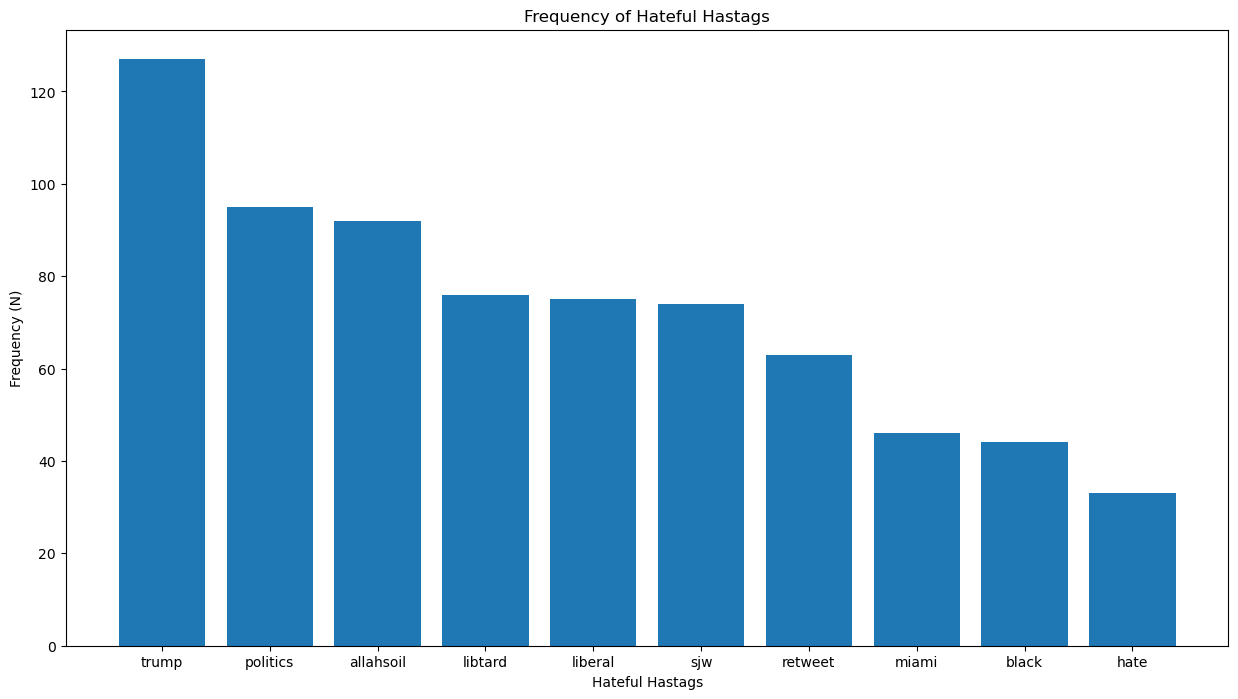

In [128]:
# Extract the Hateful Hashtag items and their counts
hateful_hastags = list(counts_hash_hatefuls.keys())
counts_hatehash = list(counts_hash_hatefuls.values())

# Create DataFrame
df_hate_hastags = pd.DataFrame({'Hashtag': hateful_hastags,'Frequency': counts_hatehash})

# Sort Dataframe by Frequency (Descending)
df_hate_hastags.sort_values(by = "Frequency", ascending = False, inplace=True)

# Top 10 Hateful hastags
top10_hateht_df = df_hate_hastags.head(10)

# Plot Top 10 Hateful hastags
plt.figure(figsize=(15,8))
plt.bar(data = top10_hateht_df, x = "Hashtag", height= "Frequency")

# Adding labels and title
plt.xlabel('Hateful Hastags')
plt.ylabel('Frequency (N)')
plt.title('Frequency of Hateful Hastags')

# Show the plot
plt.show()

### Sentiment Analysis of All tweets

In [129]:
# Function for Sentiment Analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

In [130]:
# Creating Columns for Polarity and Subjectivity
df[['polarity_score', 'subjectivity_score']] = df['cleaned_tweet'].apply(lambda tweet: pd.Series(analyze_sentiment(tweet)))


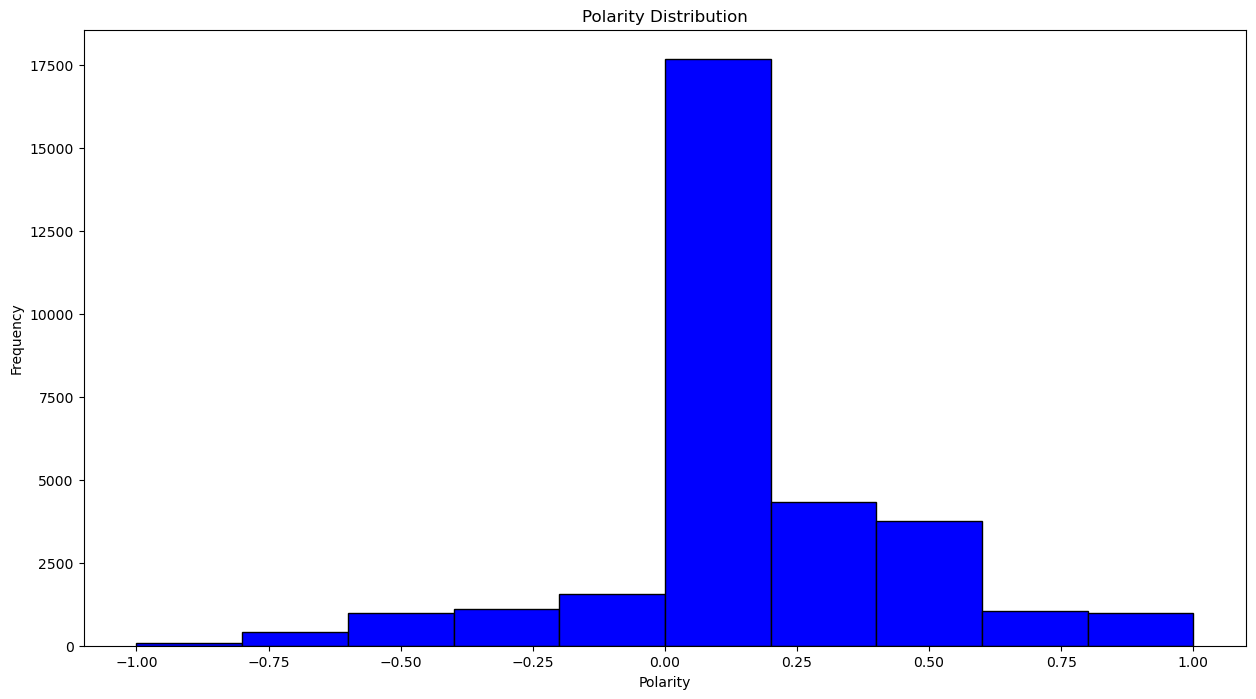

In [131]:
# Polarity Score Distribution of All Tweets
plt.figure(figsize=(15, 8))
plt.hist(df.polarity_score, bins=10, color="blue", edgecolor="black")
plt.title("Polarity Distribution")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()

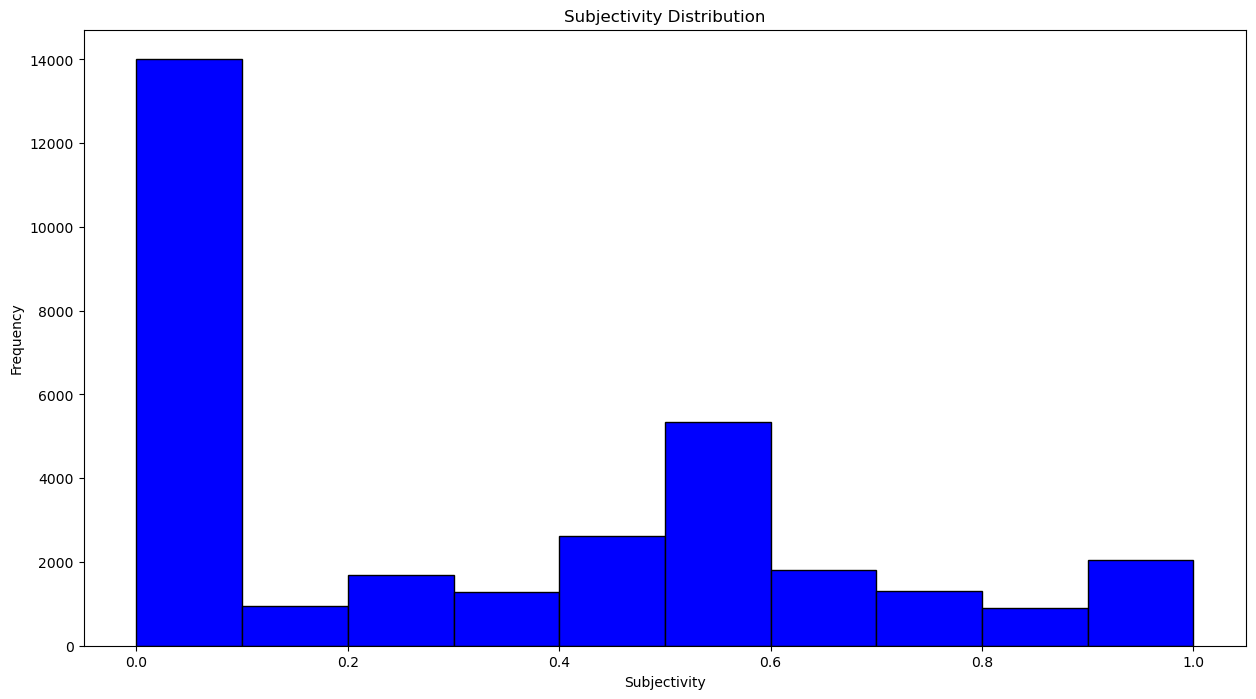

In [132]:
# Subjectivity Score Distribution of All Tweets
plt.figure(figsize=(15, 8))
plt.hist(df.subjectivity_score, bins=10, color="blue", edgecolor="black")
plt.title("Subjectivity Distribution")
plt.xlabel("Subjectivity")
plt.ylabel("Frequency")
plt.show()

### Building Hate Speech Classification Model

In [133]:
# Extracting Features for Model
vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_tweet'])

bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

bow_df.head()

,abl,absolut,accept,account,act,action,actor,actual,ad,adapt,...,yo,yoga,york,youll,young,youth,youtube,youv,yr,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
# Splitting Data into train test Split
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], random_state=42, test_size=0.20)

In [135]:
# Majority class baseline
y_pred_baseline = [0] * len(y_test)

# Evaluate accuracy of the baseline
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline accuracy: {baseline_accuracy:.2f}")

# Evaluate f1 score of the baseline
baseline_f1_score = f1_score(y_test, y_pred_baseline)
print(f"Baseline f1: {baseline_f1_score:.2f}")

Baseline accuracy: 0.93
Baseline f1: 0.00


#### Logisitic Regression

Accuracy: 94.35%

f1_score: 45.71%

classification_report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5937
           1       0.73      0.33      0.46       456

    accuracy                           0.94      6393
   macro avg       0.84      0.66      0.71      6393
weighted avg       0.93      0.94      0.93      6393


Confusion Matrix


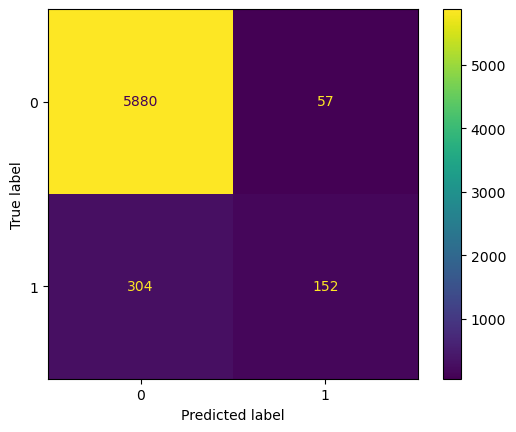

In [136]:
# training the Model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Making model predictions on Test
y_pred = lr.predict(X_test)
y_pred

# Evaluate the model (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print()

# Evaluation Model (F1_score)
f1 = f1_score(y_test, y_pred)
print(f"f1_score: {f1 * 100:.2f}%")
print()

# Evaluation Model (classification_report)
print("classification_report")
print(classification_report(y_test, y_pred))
print()


print("Confusion Matrix")
cm_display = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred),display_labels= lr.classes_)
cm_display.plot()
plt.show()

#### Naive Bayes classifier

Accuracy: 93.24%

f1_score: 51.46%

classification_report
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5937
           1       0.53      0.50      0.51       456

    accuracy                           0.93      6393
   macro avg       0.74      0.73      0.74      6393
weighted avg       0.93      0.93      0.93      6393


Confusion Matrix


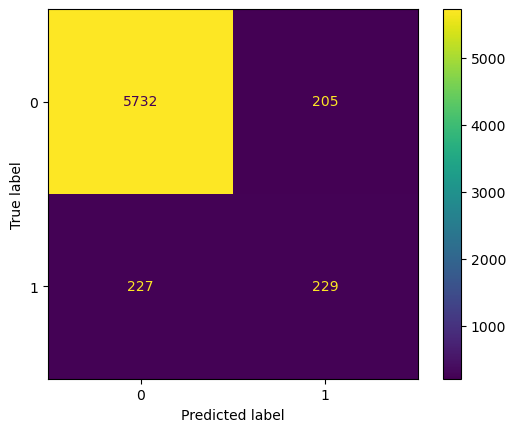

In [137]:
# Train a Naive Bayes classifier on the training set
nbc = MultinomialNB()
nbc.fit(X_train, y_train)

# Making model predictions on Test
y_pred = nbc.predict(X_test)
y_pred

# Evaluate the model (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print()

# Evaluation Model (F1_score)
f1 = f1_score(y_test, y_pred)
print(f"f1_score: {f1 * 100:.2f}%")
print()

# Evaluation Model (classification_report)
print("classification_report")
print(classification_report(y_test, y_pred))
print()


print("Confusion Matrix")
cm_display = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred),display_labels= lr.classes_)
cm_display.plot()
plt.show()

#### Random Forest Classifier

Accuracy: 94.15%

f1_score: 56.21%

classification_report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      5937
           1       0.60      0.53      0.56       456

    accuracy                           0.94      6393
   macro avg       0.78      0.75      0.77      6393
weighted avg       0.94      0.94      0.94      6393


Confusion Matrix


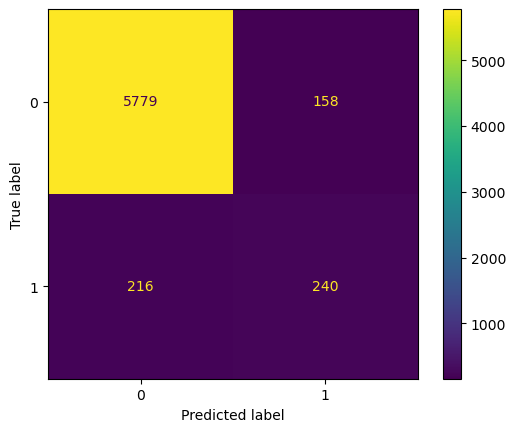

In [138]:
# Train a Random Forest classifier on the training set
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print()

# Evaluation Model (F1_score)
f1 = f1_score(y_test, y_pred)
print(f"f1_score: {f1 * 100:.2f}%")
print()

# Evaluation Model (classification_report)
print("classification_report")
print(classification_report(y_test, y_pred))
print()


print("Confusion Matrix")
cm_display = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred),display_labels= lr.classes_)
cm_display.plot()
plt.show()

#### Support Vector Classifier

Accuracy: 94.54%

f1_score: 46.39%

classification_report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5937
           1       0.77      0.33      0.46       456

    accuracy                           0.95      6393
   macro avg       0.86      0.66      0.72      6393
weighted avg       0.94      0.95      0.94      6393


Confusion Matrix


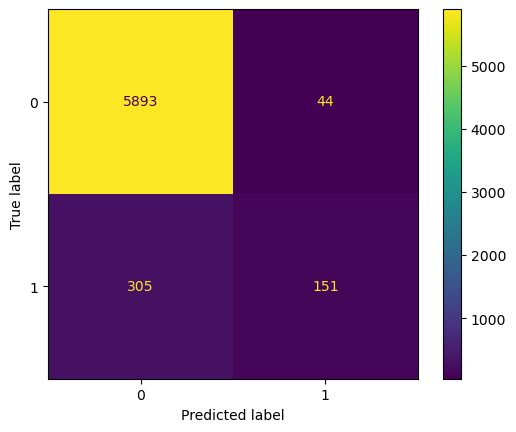

In [139]:
# Train a Support Vector classifier on the training set
svc = SVC()
svc.fit(X_train, y_train)

# Predict on the test set
y_pred = svc.predict(X_test)

# Evaluate the model (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print()

# Evaluation Model (F1_score)
f1 = f1_score(y_test, y_pred)
print(f"f1_score: {f1 * 100:.2f}%")
print()

# Evaluation Model (classification_report)
print("classification_report")
print(classification_report(y_test, y_pred))
print()


print("Confusion Matrix")
cm_display = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred),display_labels= lr.classes_)
cm_display.plot()
plt.show()

##### Hyperparameter Tuning


In [140]:
# Define the hyperparameters for GridSearch
param_grid = {
    'n_estimators': range(100, 350, 50),  
    'max_depth': range(0, 50, 10),  
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid= param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Parameters Found: ", best_params)

# Evaluate the model with the best parameters
y_pred = grid_search.best_estimator_.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

Best Parameters Found:  {'max_depth': 40, 'n_estimators': 400}
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5937
           1       0.82      0.30      0.44       456

    accuracy                           0.95      6393
   macro avg       0.88      0.65      0.71      6393
weighted avg       0.94      0.95      0.93      6393



# Resampling Data

In [141]:
# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [142]:
# training the Model
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)

LogisticRegression()

In [143]:
# Evaluation Model (accuracy_score)
accuracy_score(y_test,y_pred)

0.9454090411387455

In [144]:
# Evaluation Model (F1_score)
f1_score(y_test, y_pred)

0.43980738362760835

In [145]:
# Making model predictions on Test
y_pred = lr.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)